In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pickle

sentences = pd.read_csv('data/substance_interactions.csv')

def create_predication(row):
    sentence = ' '.join([row.SUBJECT_TEXT, row.PREDICATE, row.OBJECT_TEXT])
    sentence = sentence.replace('_', ' ').lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

def clean_target_sentences(text):
    text = re.sub(r'\s+', ' ', text)
    return text

sentences['predication'] = sentences.apply(create_predication, axis=1)
sentences['SENTENCE'] = sentences.apply(lambda x: clean_target_sentences(x.SENTENCE), axis=1)
sentences['sent_len'] = sentences.SENTENCE.str.len()

sentences = sentences.rename(columns={col: col.lower() for col in sentences.columns})
sentences = sentences[['sentence', 'predicate', 'predication', 'label', 'sent_len']]
sentences['concatenated'] = sentences.predication + '[SEP]' + sentences.sentence
sentences['label'] = sentences.label.map({'y': 1, 'n': 0})

# shuffle the dataframe
sentences = sentences.sample(frac=1, random_state=42).reset_index(drop=True)
sentences.head()

,sentence,predicate,predication,label,sent_len,concatenated
0,These results suggest that the elevation of pl...,INHIBITS,cbz-e inhibits epoxide hydrolase,0,178,cbz-e inhibits epoxide hydrolase[SEP]These res...
1,GABA affinity seemed to be identical to that o...,INTERACTS_WITH,beta 1 gamma 2 interacts with gaba,0,280,beta 1 gamma 2 interacts with gaba[SEP]GABA af...
2,The depressant effects of pressure-ejected NT ...,INTERACTS_WITH,6-ohda interacts with nt,1,165,6-ohda interacts with nt[SEP]The depressant ef...
3,As the hypoaminoacidaemic effect of insulin an...,INTERACTS_WITH,tyrosine interacts with glucagon,1,294,tyrosine interacts with glucagon[SEP]As the hy...
4,Some features of barbiturate interaction and i...,INTERACTS_WITH,nadh-cytochrome c oxidoreductase interacts wit...,1,113,nadh-cytochrome c oxidoreductase interacts wit...


# Inspect Dataset
plot distribution of LABEL and PREDICATE in the dataset, along with length of the sentence in characters

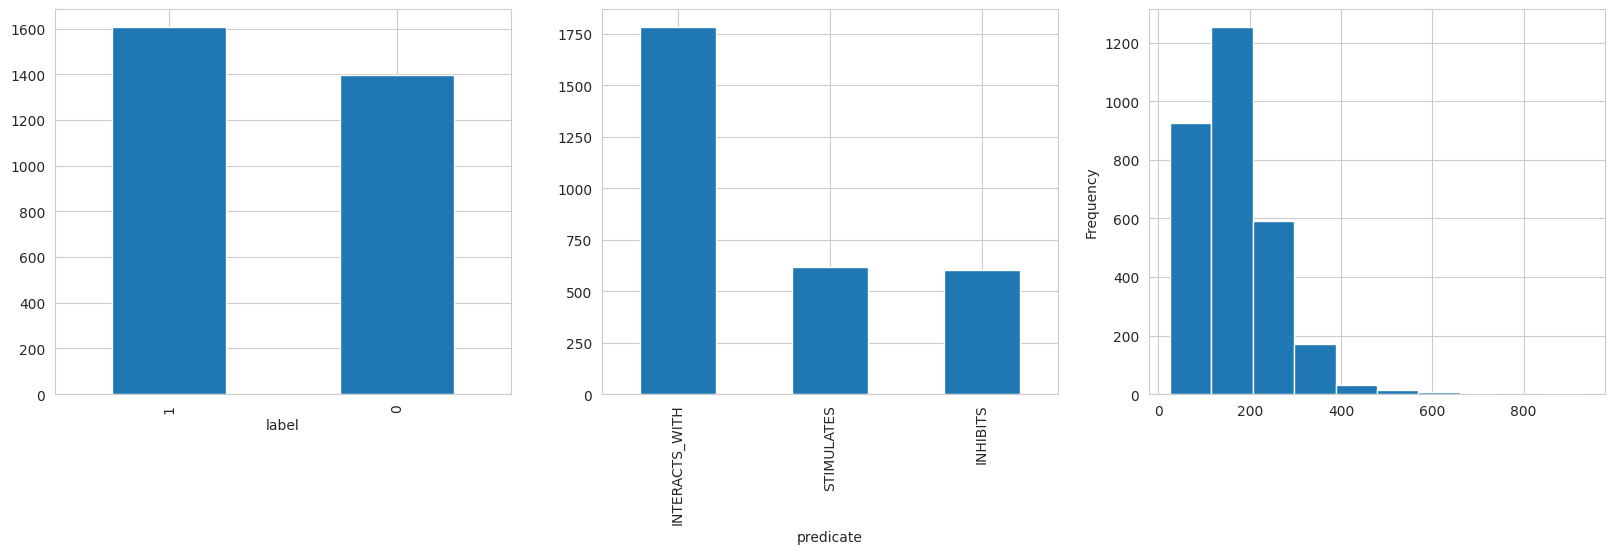

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sentences.label.value_counts().plot(kind='bar', ax=ax[0])
sentences.predicate.value_counts().plot(kind='bar', ax=ax[1])
sentences.sent_len.plot(kind='hist', ax=ax[2])
plt.show()

Do a sanity check to make sure there aren't wildly disproportionate predicates in the positive/negative labels'

<Axes: xlabel='predicate', ylabel='label'>

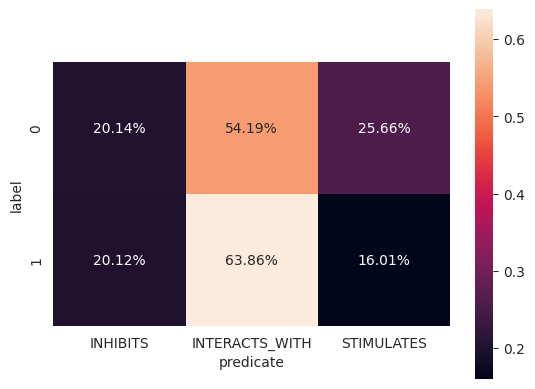

In [5]:
df = sentences.groupby(['label', 'predicate']).size().unstack()
df =df.div(df.sum(axis=1), axis=0)
sns.heatmap(df, annot=True, fmt='.2%', square=True)

# Build datasets

In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [7]:
dataset = {
    'sentence': {'text': sentences.sentence.values.tolist(),
                 'max_length': 250,},
    'predication': {'text': sentences.predication.values.tolist(),
                    'max_length': 32},
    'concatenated': {'text': sentences.concatenated.values.tolist(),
                     'max_length': 250},
    'predicate': {'text': sentences.predicate.values},
    'label': {'text': sentences.label.values}
}

test_size = 0.20

In [8]:
test_size = int(len(sentences) * test_size)
train_size = int(len(sentences)-test_size)
test_size, train_size

for col in ['sentence', 'predication', 'concatenated']:
    dataset[col]['encoded'] = tokenizer.batch_encode_plus(dataset[col]['text'], max_length=dataset[col]['max_length'], padding='max_length', return_tensors='tf', truncation=True)['input_ids']
    dataset[col]['test']=dataset[col]['encoded'][0:test_size]
    dataset[col]['train']=dataset[col]['encoded'][test_size:]

for col in ['label', 'predicate']:
    dataset[col]['test']=dataset[col]['text'][0:test_size]
    dataset[col]['train']=dataset[col]['text'][test_size:]

2023-11-10 09:01:43.941485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 09:01:43.941535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 09:01:43.941548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 09:01:43.946494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 09:01:44.967294: I tensorflow/compiler/

# Save the datasets


In [9]:
outfile = open('data/dataset.pkl', 'wb')
pickle.dump(dataset, outfile)
outfile.close()